Connecting to my Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the data, which is located on the Drive in zip folders.

In [2]:
import os
import zipfile

# Define the path to the directory where the zip files are stored
zip_dir = '/content/drive/My Drive'

# Define the path where you want to extract the images
extract_dir = '/content/images'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip each file
for file_name in os.listdir(zip_dir):
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(os.path.join(zip_dir, file_name), 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

Creating files for training, validation, and test, in the 70:15:15 ratio.

In [3]:
import shutil
from sklearn.model_selection import train_test_split

# Define the base directory where your images are located
base_dir = '/content/images'

# Define paths for training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Mapping of original class names to new class names without " 256"
class_name_mapping = {
    "Aserai Recruit 256": "Aserai Recruit",
    "Battanian Volunteer 256": "Battanian Volunteer",
    "Imperial Recruit 256": "Imperial Recruit",
    "Khuzait Nomad 256": "Khuzait Nomad",
    "Sturgian Recruit 256": "Sturgian Recruit",
    "Vlandian Recruit 256": "Vlandian Recruit"
}

# Function to create class subdirectories in the target directory
def create_class_subdirs(base_path, classes):
    for class_name in classes.values():
        os.makedirs(os.path.join(base_path, class_name), exist_ok=True)

# Create class subdirectories in train, val, and test directories
create_class_subdirs(train_dir, class_name_mapping)
create_class_subdirs(val_dir, class_name_mapping)
create_class_subdirs(test_dir, class_name_mapping)

# Split data and copy files to respective directories
for original_class_name, new_class_name in class_name_mapping.items():
    class_path = os.path.join(base_dir, original_class_name)
    images = os.listdir(class_path)

    # Split the images into training, validation, and test sets
    train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=73)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.50, random_state=73)

    # Move images to the corresponding directories
    for img in train_imgs:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, new_class_name, img))
    for img in val_imgs:
        shutil.move(os.path.join(class_path, img), os.path.join(val_dir, new_class_name, img))
    for img in test_imgs:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, new_class_name, img))

    # Optionally, remove the original class directory if it is empty
    os.rmdir(class_path)

Importing various libraries, which are used later on.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import lecun_normal
from tensorflow.keras import regularizers
from keras.layers import LeakyReLU
import os

Importing the images and their corresponding labels from the training and validation datasets.

In [5]:
# Define the paths to your datasets
train_dir = '/content/images/train'
val_dir = '/content/images/val'

# Function to load and preprocess images
def load_images_and_labels(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                if file.endswith(('.jpg')):
                    image_path = os.path.join(class_dir, file)
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                    images.append(image)
                    labels.append(i)  # Use class index as label
    return np.array(images), np.array(labels)

# Load images and labels for training and validation sets
train_images, train_labels = load_images_and_labels(train_dir)
val_images, val_labels = load_images_and_labels(val_dir)

Printing out the class names.

In [6]:
# Function to get class names from directory names
def get_class_names(directory):
    class_names = sorted(os.listdir(directory))
    return class_names

# Get class names from the training directory
class_names = get_class_names(train_dir)

# Display class names
print("Class names:", class_names)


Class names: ['Aserai Recruit', 'Battanian Volunteer', 'Imperial Recruit', 'Khuzait Nomad', 'Sturgian Recruit', 'Vlandian Recruit']


Shuffling training and validation images.

In [7]:
# Shuffle training images and labels
train_indices = np.random.permutation(len(train_images))
train_images = train_images[train_indices]
train_labels = train_labels[train_indices]

# Shuffle validation images and labels
val_indices = np.random.permutation(len(val_images))
val_images = val_images[val_indices]
val_labels = val_labels[val_indices]

Displaying a few images from training and validation to see if everything works as intended.

Training set:


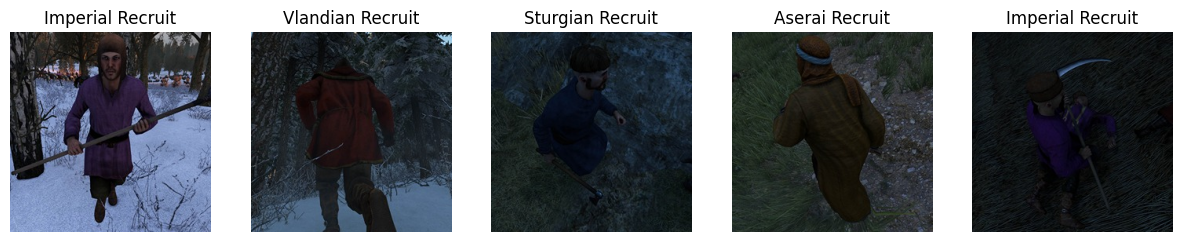

Validation set:


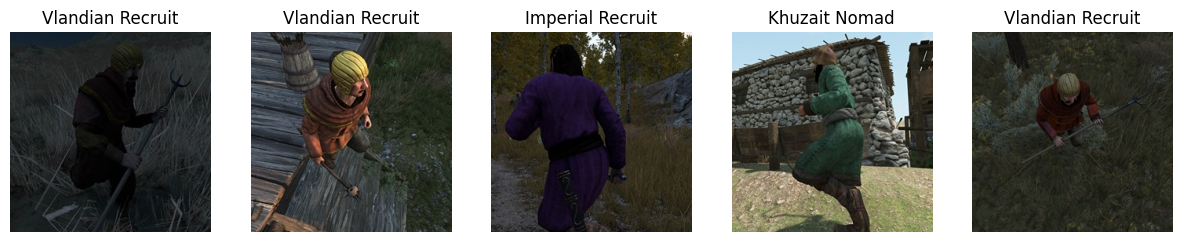

In [8]:
# Function to display images
def show_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.show()

# Display a few images from the training set
print("Training set:")
show_images(train_images, train_labels, class_names, num_images=5)

# Display a few images from the validation set
print("Validation set:")
show_images(val_images, val_labels, class_names, num_images=5)

Printing the training and validation dimensions to check if it is all as it should be.

In [9]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(2940, 256, 256, 3) (2940,)
(630, 256, 256, 3) (630,)


Image generator.

In [11]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))


Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


First model.

In [ ]:
model1 = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(6, activation='softmax')
])

model1.summary()
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 64)      0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 123, 123, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 121, 121, 64)      36928     
                                                        

Training the first model.

In [ ]:
history = model1.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 56s - loss: 1.7931 - accuracy: 0.1565 - val_loss: 1.7918 - val_accuracy: 0.1667 - 56s/epoch - 606ms/step
Epoch 2/15
92/92 - 20s - loss: 1.7920 - accuracy: 0.1510 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 219ms/step
Epoch 3/15
92/92 - 20s - loss: 1.7919 - accuracy: 0.1588 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 4/15
92/92 - 20s - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 5/15
92/92 - 20s - loss: 1.7919 - accuracy: 0.1520 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 6/15
92/92 - 20s - loss: 1.7920 - accuracy: 0.1544 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 7/15
92/92 - 20s - loss: 1.7919 - accuracy: 0.1619 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 8/15
92/92 - 20s - loss: 1.7919 - accuracy: 0.1534 - val_loss: 1.7918 - val_accuracy: 0.1667 - 20s/epoch - 220ms/step
Epoch 9/

Functions to display the results.

In [10]:
def plot_model_accuracy(history):
  loss_train = history.history['accuracy']
  loss_val = history.history['val_accuracy']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def plot_model_loss(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

Results of the first model.

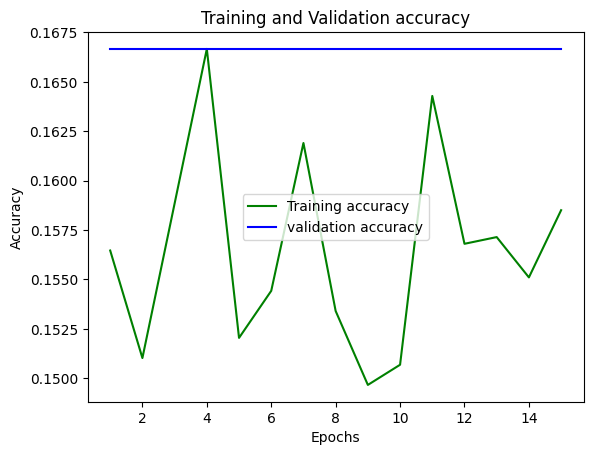

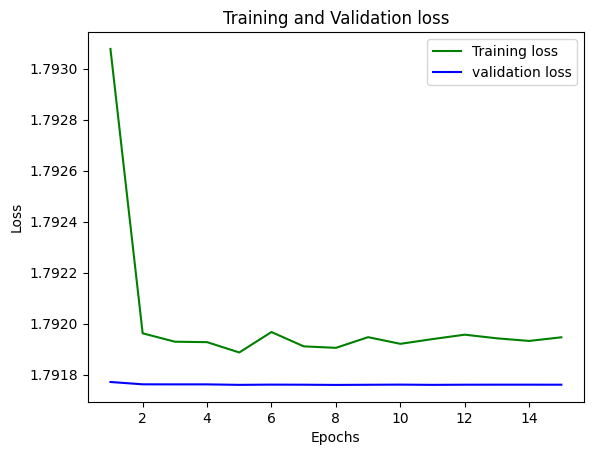

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Second model.

In [ ]:
model2 = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(6, activation='softmax')
])

model2.summary()
model2.compile(optimizer=Adam(learning_rate= 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 252, 64)      36928     
                                                                 
 conv2d_14 (Conv2D)          (None, 250, 250, 64)      36928     
                                                                 
 conv2d_15 (Conv2D)          (None, 248, 248, 64)      36928     
                                                                 
 conv2d_16 (Conv2D)          (None, 246, 246, 64)      36928     
                                                                 
 conv2d_17 (Conv2D)          (None, 244, 244, 64)      36928     
                                                                 
 conv2d_18 (Conv2D)          (None, 242, 242, 64)     

Training the second model.

In [ ]:
history = model2.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 162s - loss: 1.7926 - accuracy: 0.1588 - val_loss: 1.7918 - val_accuracy: 0.1667 - 162s/epoch - 2s/step
Epoch 2/15
92/92 - 65s - loss: 1.7920 - accuracy: 0.1575 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 703ms/step
Epoch 3/15
92/92 - 65s - loss: 1.7920 - accuracy: 0.1548 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 704ms/step
Epoch 4/15
92/92 - 65s - loss: 1.7919 - accuracy: 0.1599 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 704ms/step
Epoch 5/15
92/92 - 65s - loss: 1.7919 - accuracy: 0.1544 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 704ms/step
Epoch 6/15
92/92 - 65s - loss: 1.7919 - accuracy: 0.1599 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 704ms/step
Epoch 7/15
92/92 - 65s - loss: 1.7919 - accuracy: 0.1534 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 705ms/step
Epoch 8/15
92/92 - 65s - loss: 1.7919 - accuracy: 0.1585 - val_loss: 1.7918 - val_accuracy: 0.1667 - 65s/epoch - 704ms/step
Epoch 9/1

Results of the second model.

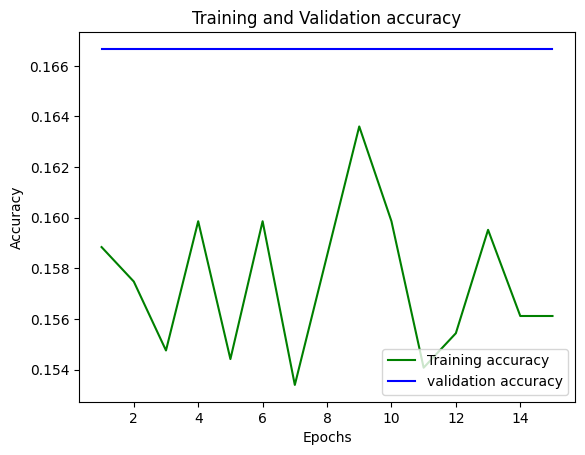

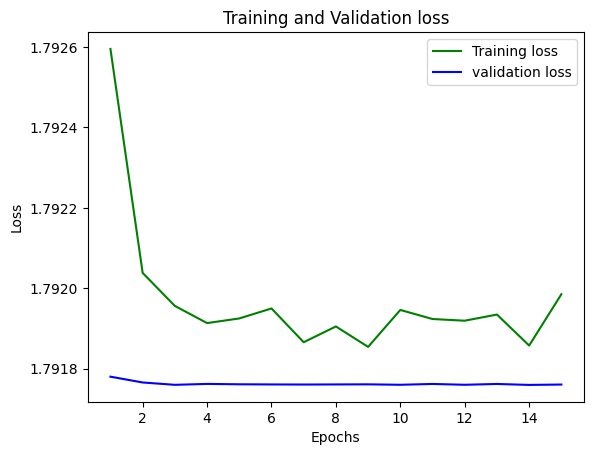

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Third model.

In [ ]:
model3 = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
])

model3.summary()

model3.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

Training the third model.

In [ ]:
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 15s - loss: 1.6542 - accuracy: 0.3031 - val_loss: 1.3771 - val_accuracy: 0.4683 - 15s/epoch - 158ms/step
Epoch 2/15
92/92 - 5s - loss: 1.0841 - accuracy: 0.5854 - val_loss: 0.8448 - val_accuracy: 0.6730 - 5s/epoch - 58ms/step
Epoch 3/15
92/92 - 6s - loss: 0.5963 - accuracy: 0.7932 - val_loss: 0.5997 - val_accuracy: 0.7619 - 6s/epoch - 64ms/step
Epoch 4/15
92/92 - 6s - loss: 0.3591 - accuracy: 0.8816 - val_loss: 0.4003 - val_accuracy: 0.8603 - 6s/epoch - 62ms/step
Epoch 5/15
92/92 - 6s - loss: 0.2759 - accuracy: 0.9048 - val_loss: 0.3328 - val_accuracy: 0.8794 - 6s/epoch - 63ms/step
Epoch 6/15
92/92 - 6s - loss: 0.1832 - accuracy: 0.9452 - val_loss: 0.2353 - val_accuracy: 0.9159 - 6s/epoch - 63ms/step
Epoch 7/15
92/92 - 6s - loss: 0.1642 - accuracy: 0.9463 - val_loss: 0.2388 - val_accuracy: 0.9190 - 6s/epoch - 62ms/step
Epoch 8/15
92/92 - 6s - loss: 0.1214 - accuracy: 0.9619 - val_loss: 0.2317 - val_accuracy: 0.9159 - 6s/epoch - 61ms/step
Epoch 9/15
92/92 - 6s - loss:

Results of the third model.

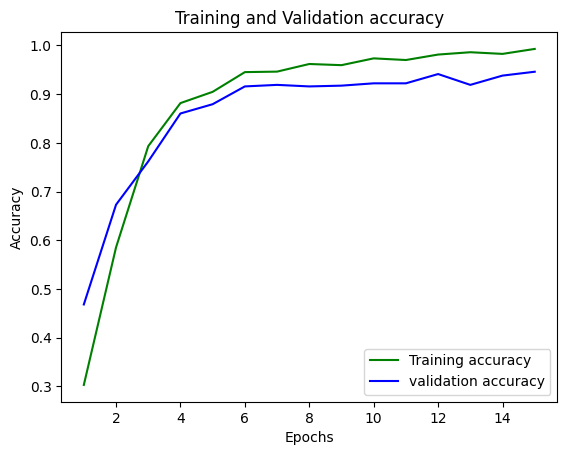

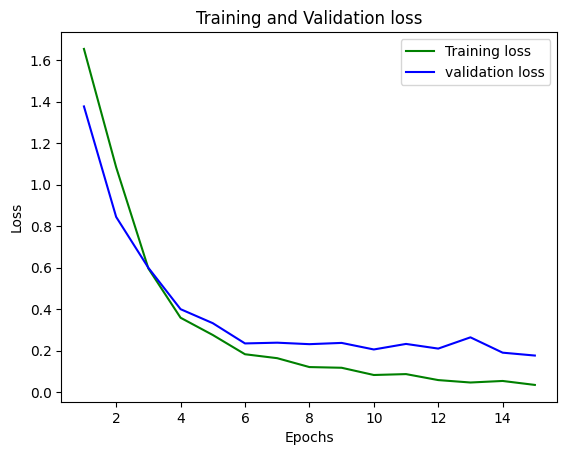

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))


Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Fourth model.

In [ ]:
# Define the model
model4 = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
])

model4.summary()

# Compile the model
model4.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

Training the fourth model.

In [ ]:
# Train the model
history = model4.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 46s - loss: 1.6801 - accuracy: 0.2881 - val_loss: 1.3896 - val_accuracy: 0.4698 - 46s/epoch - 505ms/step
Epoch 2/15
92/92 - 40s - loss: 1.0964 - accuracy: 0.5922 - val_loss: 0.6788 - val_accuracy: 0.7825 - 40s/epoch - 435ms/step
Epoch 3/15
92/92 - 40s - loss: 0.6319 - accuracy: 0.7803 - val_loss: 0.4398 - val_accuracy: 0.8698 - 40s/epoch - 433ms/step
Epoch 4/15
92/92 - 40s - loss: 0.4587 - accuracy: 0.8459 - val_loss: 0.3428 - val_accuracy: 0.8873 - 40s/epoch - 431ms/step
Epoch 5/15
92/92 - 40s - loss: 0.3862 - accuracy: 0.8748 - val_loss: 0.3032 - val_accuracy: 0.8984 - 40s/epoch - 434ms/step
Epoch 6/15
92/92 - 40s - loss: 0.3230 - accuracy: 0.8888 - val_loss: 0.2844 - val_accuracy: 0.9127 - 40s/epoch - 431ms/step
Epoch 7/15
92/92 - 40s - loss: 0.3034 - accuracy: 0.8949 - val_loss: 0.2596 - val_accuracy: 0.9127 - 40s/epoch - 430ms/step
Epoch 8/15
92/92 - 40s - loss: 0.2786 - accuracy: 0.9082 - val_loss: 0.2266 - val_accuracy: 0.9206 - 40s/epoch - 433ms/step
Epoch 9/

Results of the fourth model.

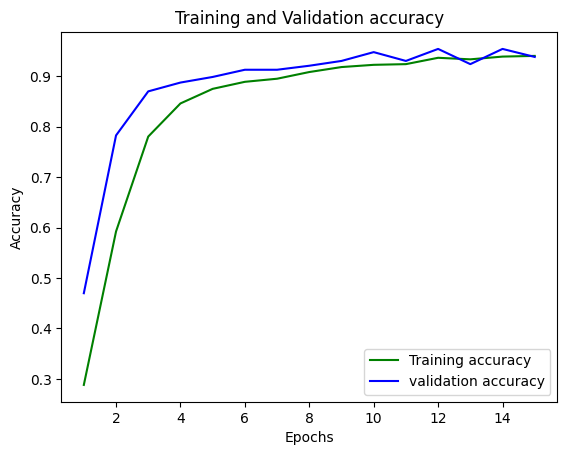

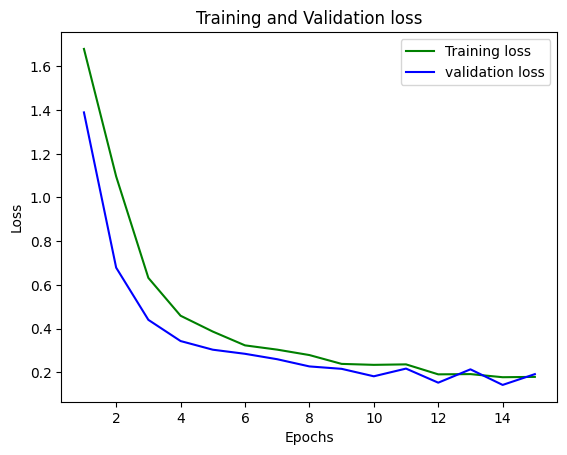

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator - data augmentation removed.

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Fifth model.

In [ ]:
# Define the model
model5 = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(6, activation='softmax')
])

model5.summary()

# Compile the model
model5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 59, 128)       7

Training the fifth model.

In [ ]:
# Train the model
history = model5.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 23s - loss: 1.5794 - accuracy: 0.3282 - val_loss: 1.1495 - val_accuracy: 0.5444 - 23s/epoch - 252ms/step
Epoch 2/15
92/92 - 8s - loss: 0.7492 - accuracy: 0.7201 - val_loss: 0.5906 - val_accuracy: 0.7714 - 8s/epoch - 85ms/step
Epoch 3/15
92/92 - 8s - loss: 0.4206 - accuracy: 0.8537 - val_loss: 0.4419 - val_accuracy: 0.8286 - 8s/epoch - 86ms/step
Epoch 4/15
92/92 - 8s - loss: 0.3031 - accuracy: 0.8942 - val_loss: 0.3944 - val_accuracy: 0.8857 - 8s/epoch - 86ms/step
Epoch 5/15
92/92 - 8s - loss: 0.2282 - accuracy: 0.9184 - val_loss: 0.2491 - val_accuracy: 0.9222 - 8s/epoch - 86ms/step
Epoch 6/15
92/92 - 8s - loss: 0.1976 - accuracy: 0.9303 - val_loss: 0.2266 - val_accuracy: 0.9222 - 8s/epoch - 86ms/step
Epoch 7/15
92/92 - 8s - loss: 0.1431 - accuracy: 0.9459 - val_loss: 0.2448 - val_accuracy: 0.9190 - 8s/epoch - 86ms/step
Epoch 8/15
92/92 - 8s - loss: 0.1492 - accuracy: 0.9456 - val_loss: 0.3126 - val_accuracy: 0.8794 - 8s/epoch - 86ms/step
Epoch 9/15
92/92 - 8s - loss:

Results of the fifth model.

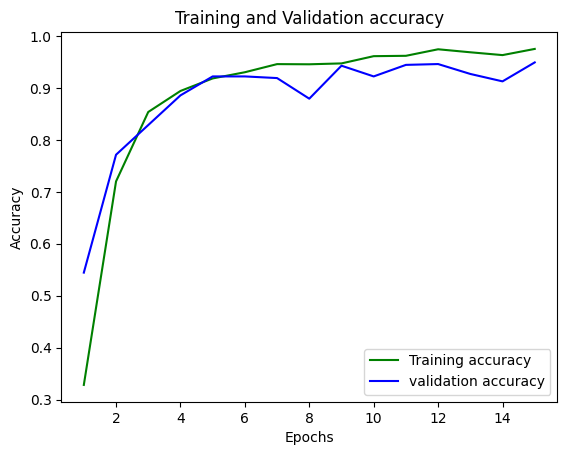

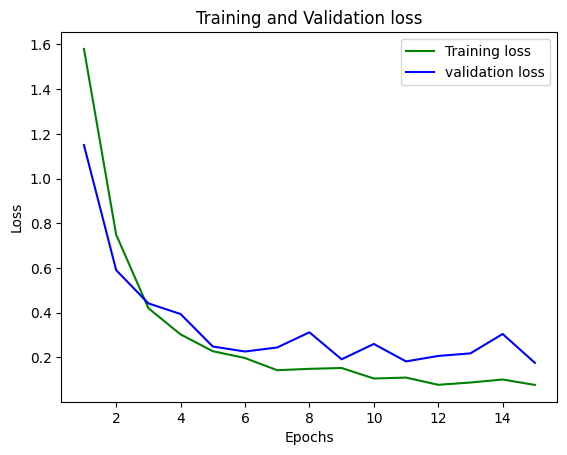

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator.

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Sixth model.

In [ ]:
# Define the model with SELU
model6 = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='selu', kernel_initializer=lecun_normal(), input_shape=(256, 256, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.Conv2D(64, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.Conv2D(128, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(256, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.Conv2D(256, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.Conv2D(256, (3, 3), activation='selu', kernel_initializer=lecun_normal()),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='selu', kernel_initializer=lecun_normal()),
  layers.Dense(6, activation='softmax')
])

model6.summary()

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 59, 59, 128)       7

Training the sixth model.

In [ ]:
# Train the model
history = model6.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 29s - loss: 2.0000 - accuracy: 0.6364 - val_loss: 0.6151 - val_accuracy: 0.7540 - 29s/epoch - 316ms/step
Epoch 2/15
92/92 - 9s - loss: 0.3851 - accuracy: 0.8656 - val_loss: 0.6266 - val_accuracy: 0.8032 - 9s/epoch - 93ms/step
Epoch 3/15
92/92 - 9s - loss: 0.1998 - accuracy: 0.9357 - val_loss: 0.3640 - val_accuracy: 0.8762 - 9s/epoch - 94ms/step
Epoch 4/15
92/92 - 9s - loss: 0.0906 - accuracy: 0.9718 - val_loss: 0.3374 - val_accuracy: 0.8984 - 9s/epoch - 93ms/step
Epoch 5/15
92/92 - 9s - loss: 0.0570 - accuracy: 0.9827 - val_loss: 0.3673 - val_accuracy: 0.8841 - 9s/epoch - 93ms/step
Epoch 6/15
92/92 - 9s - loss: 0.0368 - accuracy: 0.9915 - val_loss: 0.3410 - val_accuracy: 0.8937 - 9s/epoch - 94ms/step
Epoch 7/15
92/92 - 9s - loss: 0.0291 - accuracy: 0.9935 - val_loss: 0.4284 - val_accuracy: 0.8825 - 9s/epoch - 94ms/step
Epoch 8/15
92/92 - 9s - loss: 0.1282 - accuracy: 0.9575 - val_loss: 0.7658 - val_accuracy: 0.8048 - 9s/epoch - 94ms/step
Epoch 9/15
92/92 - 9s - loss:

Results of the sixth model.

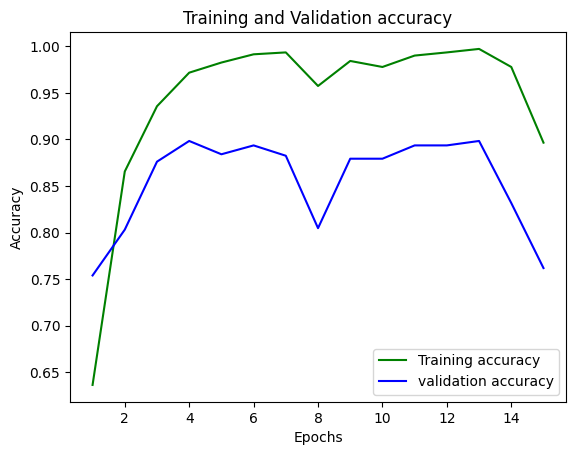

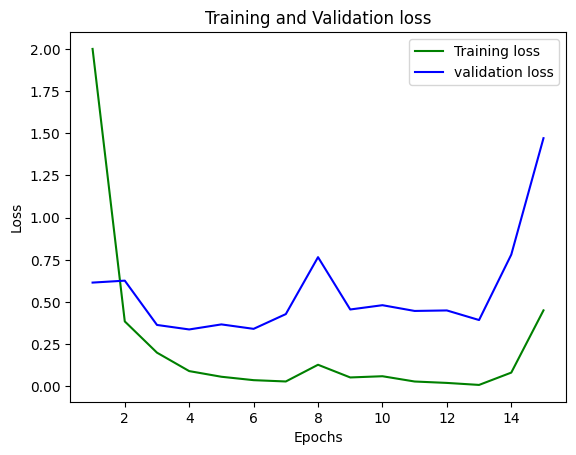

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator.

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Seventh model.

In [ ]:
# Define the model with Leaky ReLU activations
model7 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(256, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.Conv2D(256, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.Conv2D(256, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model7.summary()

# Compile the model
model7.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 64)      36928     
                                                        

Training the seventh model.

In [ ]:
# Train the model
history = model7.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 29s - loss: 1.5061 - accuracy: 0.3469 - val_loss: 1.0800 - val_accuracy: 0.5460 - 29s/epoch - 313ms/step
Epoch 2/15
92/92 - 9s - loss: 0.7854 - accuracy: 0.6908 - val_loss: 0.4837 - val_accuracy: 0.8286 - 9s/epoch - 93ms/step
Epoch 3/15
92/92 - 9s - loss: 0.3826 - accuracy: 0.8622 - val_loss: 0.3802 - val_accuracy: 0.8746 - 9s/epoch - 93ms/step
Epoch 4/15
92/92 - 9s - loss: 0.2497 - accuracy: 0.9146 - val_loss: 0.3275 - val_accuracy: 0.8841 - 9s/epoch - 93ms/step
Epoch 5/15
92/92 - 9s - loss: 0.2014 - accuracy: 0.9272 - val_loss: 0.2376 - val_accuracy: 0.9175 - 9s/epoch - 93ms/step
Epoch 6/15
92/92 - 9s - loss: 0.1876 - accuracy: 0.9313 - val_loss: 0.3033 - val_accuracy: 0.8952 - 9s/epoch - 93ms/step
Epoch 7/15
92/92 - 9s - loss: 0.1462 - accuracy: 0.9483 - val_loss: 0.2170 - val_accuracy: 0.9302 - 9s/epoch - 93ms/step
Epoch 8/15
92/92 - 9s - loss: 0.0969 - accuracy: 0.9684 - val_loss: 0.2470 - val_accuracy: 0.9222 - 9s/epoch - 94ms/step
Epoch 9/15
92/92 - 9s - loss:

Results of the seventh model.

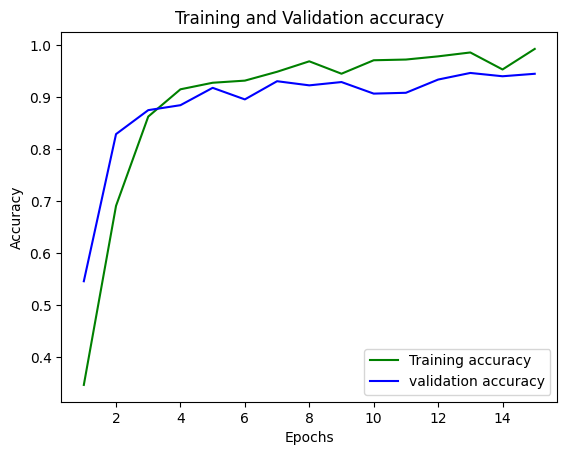

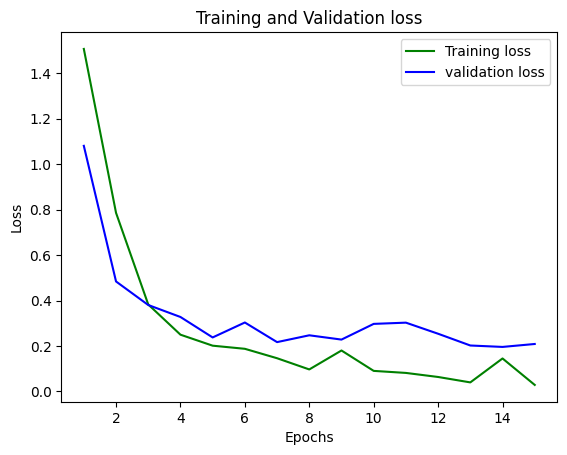

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator.

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Eighth model.

In [ ]:
# Define the model
model8 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model8.summary()

# Compile the model
model8.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the eighth model.

In [ ]:
# Train the model
history = model8.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 17s - loss: 1.5433 - accuracy: 0.3704 - val_loss: 1.0711 - val_accuracy: 0.6016 - 17s/epoch - 189ms/step
Epoch 2/15
92/92 - 6s - loss: 0.7290 - accuracy: 0.7418 - val_loss: 0.5295 - val_accuracy: 0.8175 - 6s/epoch - 66ms/step
Epoch 3/15
92/92 - 6s - loss: 0.3606 - accuracy: 0.8796 - val_loss: 0.3680 - val_accuracy: 0.8730 - 6s/epoch - 65ms/step
Epoch 4/15
92/92 - 6s - loss: 0.2514 - accuracy: 0.9211 - val_loss: 0.3556 - val_accuracy: 0.8762 - 6s/epoch - 66ms/step
Epoch 5/15
92/92 - 6s - loss: 0.1931 - accuracy: 0.9378 - val_loss: 0.2381 - val_accuracy: 0.9143 - 6s/epoch - 66ms/step
Epoch 6/15
92/92 - 6s - loss: 0.1600 - accuracy: 0.9473 - val_loss: 0.2821 - val_accuracy: 0.9032 - 6s/epoch - 65ms/step
Epoch 7/15
92/92 - 6s - loss: 0.1230 - accuracy: 0.9578 - val_loss: 0.2374 - val_accuracy: 0.9206 - 6s/epoch - 65ms/step
Epoch 8/15
92/92 - 6s - loss: 0.1191 - accuracy: 0.9595 - val_loss: 0.2222 - val_accuracy: 0.9254 - 6s/epoch - 65ms/step
Epoch 9/15
92/92 - 6s - loss:

Results of the eighth model.

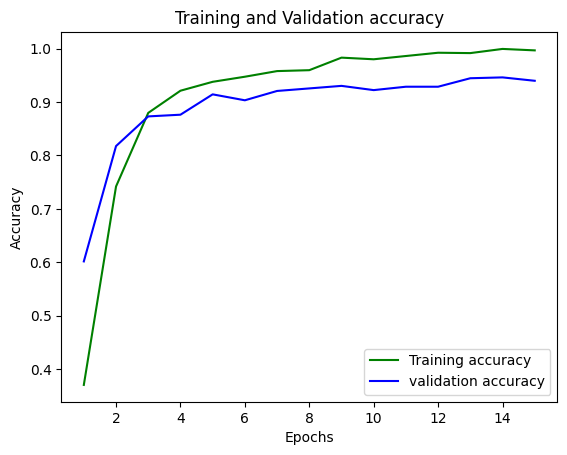

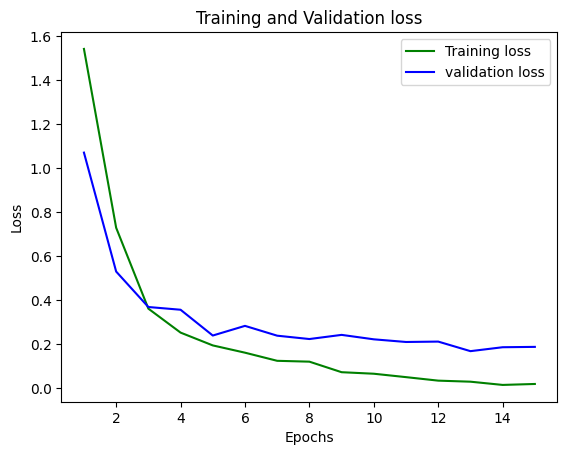

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Ninth model.

In [ ]:
# Define the model
model9 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model9.summary()

# Compile the model
model9.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the ninth model.

In [ ]:
# Train the model
history = model9.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 49s - loss: 1.5736 - accuracy: 0.3456 - val_loss: 1.1546 - val_accuracy: 0.5270 - 49s/epoch - 534ms/step
Epoch 2/15
92/92 - 40s - loss: 0.8847 - accuracy: 0.6690 - val_loss: 0.5090 - val_accuracy: 0.8444 - 40s/epoch - 440ms/step
Epoch 3/15
92/92 - 40s - loss: 0.4798 - accuracy: 0.8398 - val_loss: 0.4056 - val_accuracy: 0.8492 - 40s/epoch - 435ms/step
Epoch 4/15
92/92 - 40s - loss: 0.3725 - accuracy: 0.8718 - val_loss: 0.2791 - val_accuracy: 0.9111 - 40s/epoch - 438ms/step
Epoch 5/15
92/92 - 42s - loss: 0.3223 - accuracy: 0.8915 - val_loss: 0.2781 - val_accuracy: 0.9000 - 42s/epoch - 453ms/step
Epoch 6/15
92/92 - 40s - loss: 0.2623 - accuracy: 0.9129 - val_loss: 0.2796 - val_accuracy: 0.8937 - 40s/epoch - 430ms/step
Epoch 7/15
92/92 - 40s - loss: 0.2478 - accuracy: 0.9119 - val_loss: 0.2155 - val_accuracy: 0.9175 - 40s/epoch - 435ms/step
Epoch 8/15
92/92 - 40s - loss: 0.2117 - accuracy: 0.9272 - val_loss: 0.1631 - val_accuracy: 0.9460 - 40s/epoch - 433ms/step
Epoch 9/

Results of the ninth model.

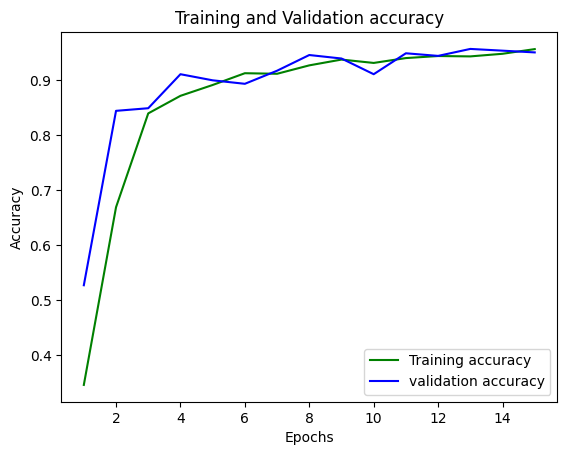

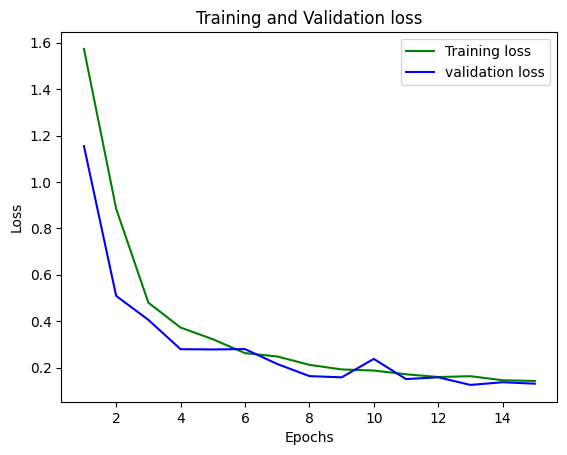

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Tenth model.

In [ ]:
# Define the model
model10 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model10.summary()

# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the tenth model.

In [ ]:
# Train the model
history = model10.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 48s - loss: 1.5360 - accuracy: 0.3793 - val_loss: 1.1139 - val_accuracy: 0.5873 - 48s/epoch - 524ms/step
Epoch 2/15
92/92 - 39s - loss: 0.7803 - accuracy: 0.7170 - val_loss: 0.4960 - val_accuracy: 0.8365 - 39s/epoch - 424ms/step
Epoch 3/15
92/92 - 39s - loss: 0.4123 - accuracy: 0.8643 - val_loss: 0.3285 - val_accuracy: 0.8841 - 39s/epoch - 427ms/step
Epoch 4/15
92/92 - 40s - loss: 0.2584 - accuracy: 0.9156 - val_loss: 0.2892 - val_accuracy: 0.8984 - 40s/epoch - 430ms/step
Epoch 5/15
92/92 - 39s - loss: 0.2294 - accuracy: 0.9214 - val_loss: 0.2143 - val_accuracy: 0.9270 - 39s/epoch - 424ms/step
Epoch 6/15
92/92 - 39s - loss: 0.1776 - accuracy: 0.9398 - val_loss: 0.2124 - val_accuracy: 0.9222 - 39s/epoch - 423ms/step
Epoch 7/15
92/92 - 39s - loss: 0.1754 - accuracy: 0.9388 - val_loss: 0.2454 - val_accuracy: 0.9143 - 39s/epoch - 428ms/step
Epoch 8/15
92/92 - 39s - loss: 0.1431 - accuracy: 0.9497 - val_loss: 0.1731 - val_accuracy: 0.9429 - 39s/epoch - 425ms/step
Epoch 9/

Results of the tenth model.

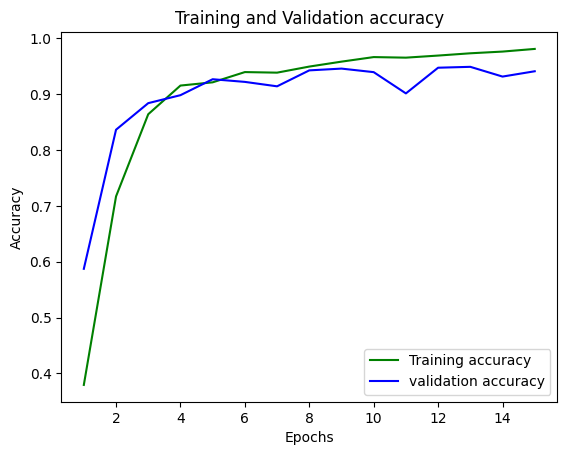

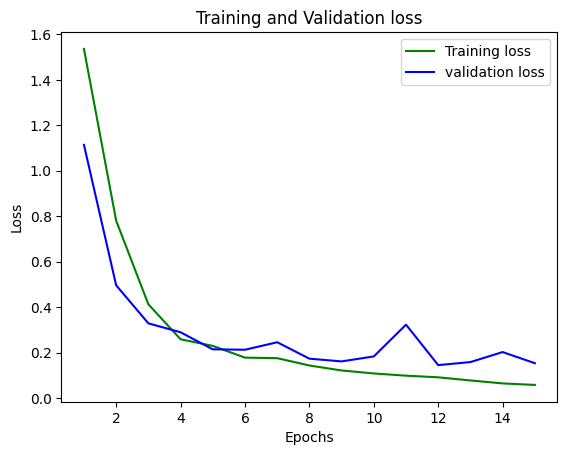

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator - data augmentation removed.

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale=1.0/255.)
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Eleventh model.

In [ ]:
# Define the model
model11 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dropout(0.1),
  layers.Dense(6, activation='softmax')
])

model11.summary()

# Compile the model
model11.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the eleventh model.

In [ ]:
# Train the model
history = model11.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 18s - loss: 1.5690 - accuracy: 0.3537 - val_loss: 1.2030 - val_accuracy: 0.5476 - 18s/epoch - 197ms/step
Epoch 2/15
92/92 - 6s - loss: 0.9133 - accuracy: 0.6524 - val_loss: 0.7149 - val_accuracy: 0.7429 - 6s/epoch - 67ms/step
Epoch 3/15
92/92 - 6s - loss: 0.4688 - accuracy: 0.8364 - val_loss: 0.4162 - val_accuracy: 0.8476 - 6s/epoch - 65ms/step
Epoch 4/15
92/92 - 6s - loss: 0.2653 - accuracy: 0.9129 - val_loss: 0.2772 - val_accuracy: 0.9063 - 6s/epoch - 65ms/step
Epoch 5/15
92/92 - 6s - loss: 0.1896 - accuracy: 0.9391 - val_loss: 0.2864 - val_accuracy: 0.9063 - 6s/epoch - 65ms/step
Epoch 6/15
92/92 - 6s - loss: 0.1547 - accuracy: 0.9531 - val_loss: 0.2467 - val_accuracy: 0.9270 - 6s/epoch - 67ms/step
Epoch 7/15
92/92 - 6s - loss: 0.1132 - accuracy: 0.9677 - val_loss: 0.2695 - val_accuracy: 0.9095 - 6s/epoch - 65ms/step
Epoch 8/15
92/92 - 6s - loss: 0.0899 - accuracy: 0.9741 - val_loss: 0.2294 - val_accuracy: 0.9222 - 6s/epoch - 65ms/step
Epoch 9/15
92/92 - 6s - loss:

Results of the eleventh model.

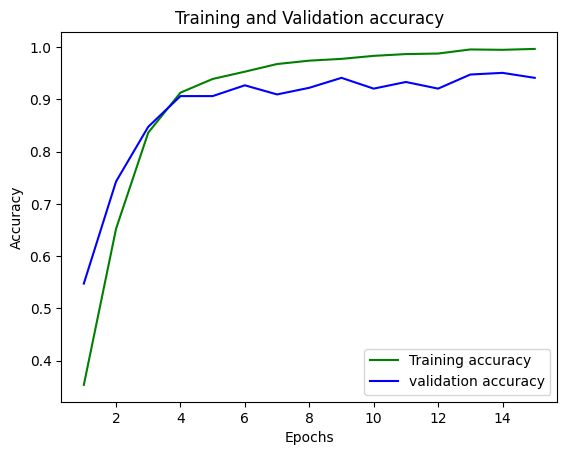

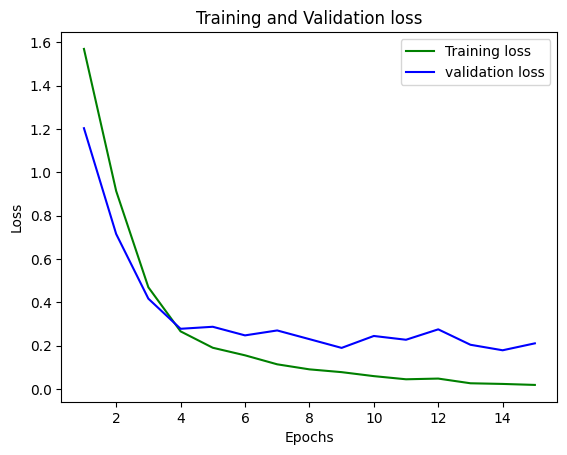

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=7.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Twelfth model.

In [ ]:
# Define the model
model12 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model12.summary()

# Compile the model
model12.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

Training the twelfth model.

In [ ]:
# Train the model
history = model12.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/15
92/92 - 49s - loss: 1.6015 - accuracy: 0.3367 - val_loss: 1.1758 - val_accuracy: 0.5476 - 49s/epoch - 537ms/step
Epoch 2/15
92/92 - 40s - loss: 0.8755 - accuracy: 0.6735 - val_loss: 0.5833 - val_accuracy: 0.7841 - 40s/epoch - 430ms/step
Epoch 3/15
92/92 - 40s - loss: 0.4711 - accuracy: 0.8405 - val_loss: 0.3751 - val_accuracy: 0.8714 - 40s/epoch - 432ms/step
Epoch 4/15
92/92 - 40s - loss: 0.3381 - accuracy: 0.8867 - val_loss: 0.3148 - val_accuracy: 0.8952 - 40s/epoch - 436ms/step
Epoch 5/15
92/92 - 40s - loss: 0.2814 - accuracy: 0.9031 - val_loss: 0.2503 - val_accuracy: 0.9238 - 40s/epoch - 435ms/step
Epoch 6/15
92/92 - 40s - loss: 0.2312 - accuracy: 0.9204 - val_loss: 0.2541 - val_accuracy: 0.9159 - 40s/epoch - 437ms/step
Epoch 7/15
92/92 - 40s - loss: 0.2286 - accuracy: 0.9116 - val_loss: 0.2391 - val_accuracy: 0.9159 - 40s/epoch - 436ms/step
Epoch 8/15
92/92 - 40s - loss: 0.1713 - accuracy: 0.9408 - val_loss: 0.1902 - val_accuracy: 0.9413 - 40s/epoch - 435ms/step
Epoch 9/

Results of the twelfth model.

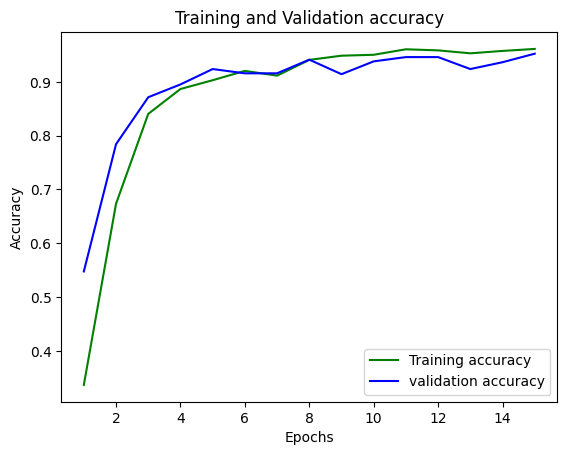

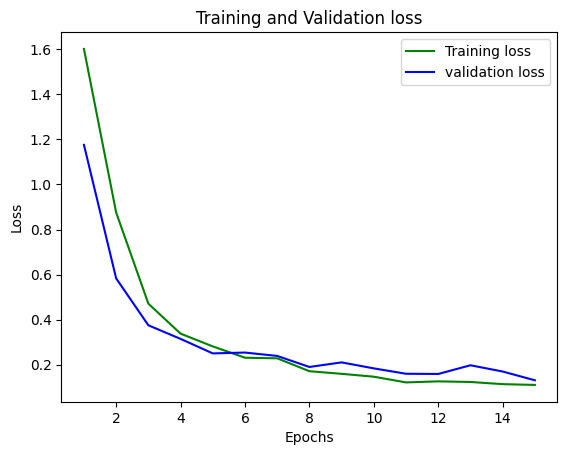

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=7.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Thirteenth model.

In [ ]:
# Define the model
model13 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model13.summary()

# Compile the model
model13.compile(optimizer=Adam(learning_rate=0.00007),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the thirteenth model.

In [ ]:
# Train the model
history = model13.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=35,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/35
92/92 - 49s - loss: 1.6544 - accuracy: 0.3034 - val_loss: 1.3794 - val_accuracy: 0.4397 - 49s/epoch - 535ms/step
Epoch 2/35
92/92 - 40s - loss: 1.0865 - accuracy: 0.5837 - val_loss: 0.7723 - val_accuracy: 0.7175 - 40s/epoch - 431ms/step
Epoch 3/35
92/92 - 40s - loss: 0.6610 - accuracy: 0.7697 - val_loss: 0.5346 - val_accuracy: 0.7952 - 40s/epoch - 435ms/step
Epoch 4/35
92/92 - 40s - loss: 0.4338 - accuracy: 0.8578 - val_loss: 0.3483 - val_accuracy: 0.8683 - 40s/epoch - 432ms/step
Epoch 5/35
92/92 - 40s - loss: 0.3318 - accuracy: 0.8813 - val_loss: 0.3078 - val_accuracy: 0.8873 - 40s/epoch - 431ms/step
Epoch 6/35
92/92 - 40s - loss: 0.2907 - accuracy: 0.9048 - val_loss: 0.2509 - val_accuracy: 0.9206 - 40s/epoch - 432ms/step
Epoch 7/35
92/92 - 40s - loss: 0.2665 - accuracy: 0.9109 - val_loss: 0.2632 - val_accuracy: 0.8952 - 40s/epoch - 431ms/step
Epoch 8/35
92/92 - 40s - loss: 0.2376 - accuracy: 0.9163 - val_loss: 0.2375 - val_accuracy: 0.9270 - 40s/epoch - 431ms/step
Epoch 9/

Results of the thirteenth model.

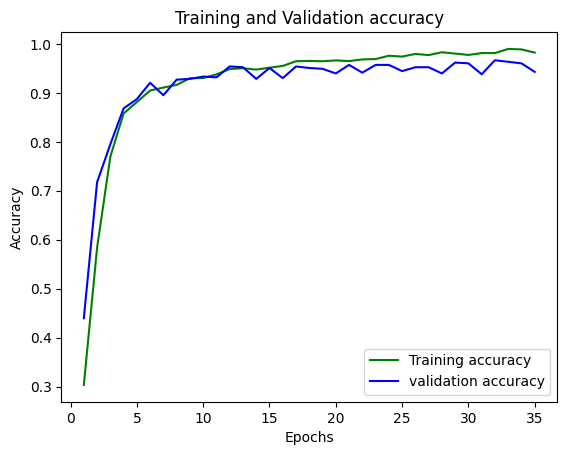

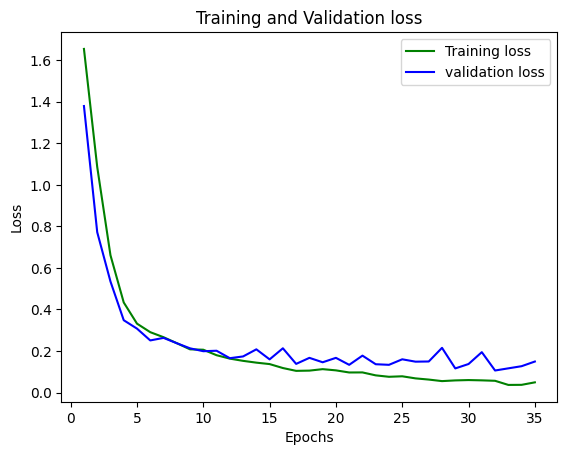

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Fourteenth model.

In [ ]:
# Define the model
model14 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model14.summary()

# Compile the model
model14.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the fourteenth model.

In [ ]:
# Train the model
history = model14.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=35,
                    validation_steps=len(validation_generator),
                    verbose=2)

Epoch 1/35
92/92 - 49s - loss: 1.5839 - accuracy: 0.3432 - val_loss: 1.1602 - val_accuracy: 0.5492 - 49s/epoch - 533ms/step
Epoch 2/35
92/92 - 40s - loss: 0.8942 - accuracy: 0.6656 - val_loss: 0.5735 - val_accuracy: 0.8032 - 40s/epoch - 435ms/step
Epoch 3/35
92/92 - 40s - loss: 0.5289 - accuracy: 0.8088 - val_loss: 0.3813 - val_accuracy: 0.8571 - 40s/epoch - 435ms/step
Epoch 4/35
92/92 - 40s - loss: 0.3678 - accuracy: 0.8745 - val_loss: 0.2496 - val_accuracy: 0.9254 - 40s/epoch - 434ms/step
Epoch 5/35
92/92 - 40s - loss: 0.3110 - accuracy: 0.8833 - val_loss: 0.2676 - val_accuracy: 0.9079 - 40s/epoch - 435ms/step
Epoch 6/35
92/92 - 40s - loss: 0.2742 - accuracy: 0.9068 - val_loss: 0.2354 - val_accuracy: 0.9127 - 40s/epoch - 436ms/step
Epoch 7/35
92/92 - 40s - loss: 0.2349 - accuracy: 0.9221 - val_loss: 0.2057 - val_accuracy: 0.9381 - 40s/epoch - 432ms/step
Epoch 8/35
92/92 - 40s - loss: 0.2145 - accuracy: 0.9293 - val_loss: 0.1841 - val_accuracy: 0.9413 - 40s/epoch - 434ms/step
Epoch 9/

Results of the fourteenth model.

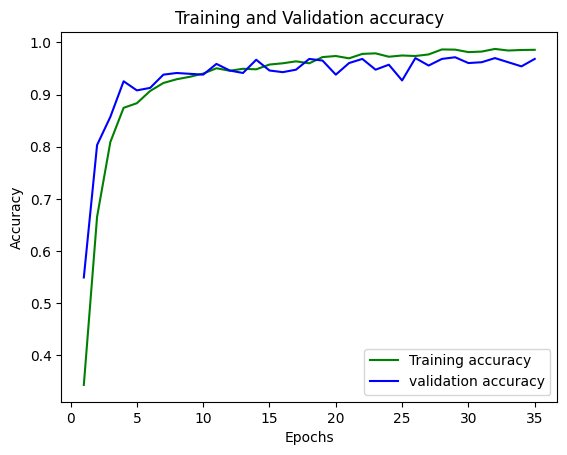

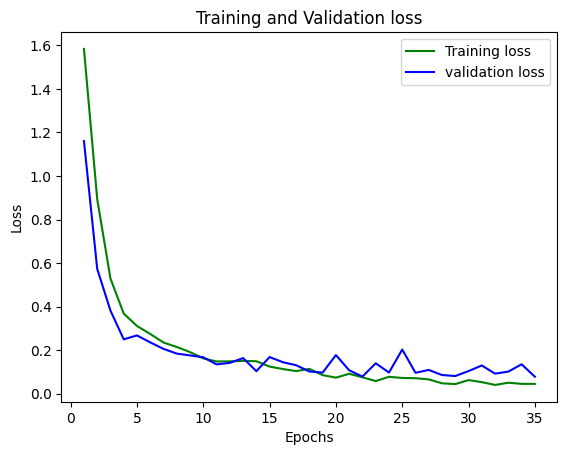

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Creating a directory to save models.

In [ ]:
save_dir = 'content/best_model'
os.makedirs(save_dir, exist_ok=True)

Image generator with data augmentation.

In [ ]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Fifteenth model.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Define the model
model15 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model15.summary()

# Define the checkpoint callback to save the model at each epoch
checkpoint_callback = ModelCheckpoint(
    'content/best_model/epoch_{epoch:02d}.h5',  # Save the model for each epoch
    save_weights_only=False,  # Save the full model
    save_freq='epoch'  # Save every epoch
)

# Compile the model
model15.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

Training the fifteenth model.

In [ ]:
# Train the model
history = model15.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=100,
                    validation_steps=len(validation_generator),
                    verbose=2,
                    callbacks=[checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 - 50s - loss: 1.6089 - accuracy: 0.3265 - val_loss: 1.2337 - val_accuracy: 0.5333 - 50s/epoch - 541ms/step
Epoch 2/100
92/92 - 41s - loss: 0.9309 - accuracy: 0.6466 - val_loss: 0.5226 - val_accuracy: 0.8222 - 41s/epoch - 441ms/step
Epoch 3/100
92/92 - 40s - loss: 0.5128 - accuracy: 0.8167 - val_loss: 0.3464 - val_accuracy: 0.8889 - 40s/epoch - 436ms/step
Epoch 4/100
92/92 - 40s - loss: 0.3597 - accuracy: 0.8799 - val_loss: 0.2717 - val_accuracy: 0.9063 - 40s/epoch - 438ms/step
Epoch 5/100
92/92 - 41s - loss: 0.2956 - accuracy: 0.9014 - val_loss: 0.2285 - val_accuracy: 0.9349 - 41s/epoch - 441ms/step
Epoch 6/100
92/92 - 41s - loss: 0.2782 - accuracy: 0.9010 - val_loss: 0.2312 - val_accuracy: 0.9206 - 41s/epoch - 440ms/step
Epoch 7/100
92/92 - 40s - loss: 0.2255 - accuracy: 0.9248 - val_loss: 0.1888 - val_accuracy: 0.9317 - 40s/epoch - 440ms/step
Epoch 8/100
92/92 - 41s - loss: 0.2219 - accuracy: 0.9214 - val_loss: 0.1867 - val_accuracy: 0.9349 - 41s/epoch - 446ms/step
Epoch 9/100


Results of the fifteenth model.

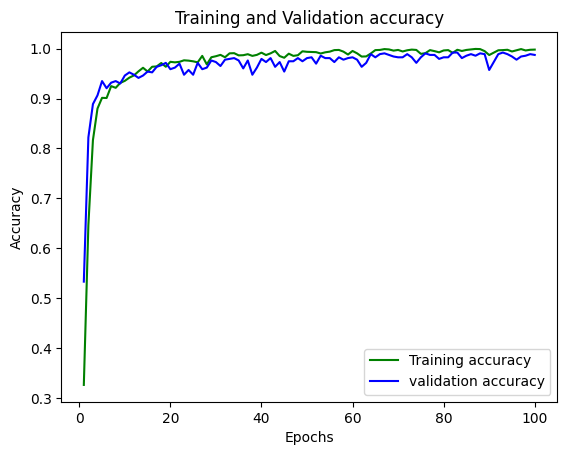

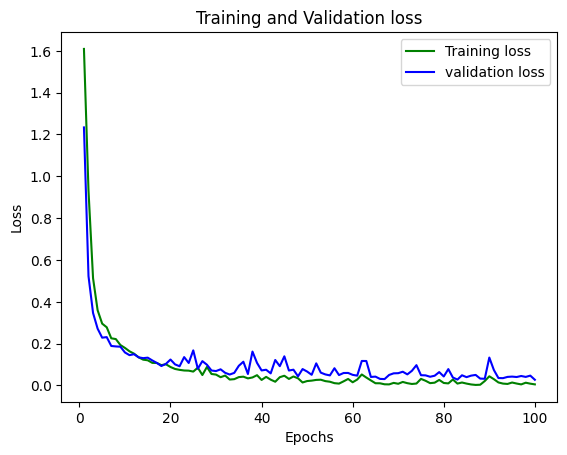

In [ ]:
plot_model_accuracy(history)
plot_model_loss(history)

Choosing the best epoch as the best model.

In [ ]:
# Choose and load the best epoch model after training
epoch_to_load = 82
final_model = load_model(f'content/best_model/epoch_{epoch_to_load:02d}.h5')

Final results.

In [ ]:
# Define the path to your test directory
test_dir = '/content/images/test'

# Data generator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=32,
                                                  class_mode='sparse',
                                                  target_size=(256, 256),
                                                  shuffle=True)

# Evaluate the model on the test set
test_loss, test_accuracy = final_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Found 630 images belonging to 6 classes.
20/20 [==============================] - 1s 48ms/step - loss: 0.1294 - accuracy: 0.9651
Test Accuracy: 96.51%
Test Loss: 0.1294


Trying to get better results with transfer learning.

In [14]:
from tensorflow.keras.applications import MobileNet

# Load the pre-trained MobileNet model without the top classification layer
pre_trained_model = MobileNet(weights='imagenet',
                              include_top=False,
                              input_shape=(256, 256, 3))

# Freeze layers so that they cannot be trained, this is crucial part of Transfer learning
pre_trained_model.trainable = False
for layer in pre_trained_model.layers:
  layer.trainable = False

Sixteenth model.

In [15]:
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

# Our output is different than the output from the (part of) pretrained network,
# that is why we need to add our layers to produce desired output (in our case 2 classes, i.e. 0 or 1)

model16 = keras.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(512),
    LeakyReLU(alpha=0.1),
    layers.Dense(6, activation='softmax')
])

model16.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               33554944  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 36786886 (140.33 MB)
Trainable params: 33558022 (128.01 MB)
Non-trainable params: 3228864 (12.32 MB)
_____

Preparing to save the models in each epoch.


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

save_dir = 'content/best_model_tf'
os.makedirs(save_dir, exist_ok=True)

# Define the checkpoint callback to save the model at each epoch
checkpoint_callback = ModelCheckpoint(
    'content/best_model_tf/epoch_{epoch:02d}.h5',  # Save the model for each epoch
    save_weights_only=False,  # Save the full model
    save_freq='epoch'  # Save every epoch
)

Training the sixteenth model.

In [18]:
history = model16.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=150,
                    validation_steps=len(validation_generator),
                    verbose=2,
                    callbacks=[checkpoint_callback])

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 - 14s - loss: 2.8151 - accuracy: 0.6571 - val_loss: 0.6396 - val_accuracy: 0.8079 - 14s/epoch - 152ms/step
Epoch 2/150
92/92 - 8s - loss: 0.2782 - accuracy: 0.9245 - val_loss: 0.2460 - val_accuracy: 0.9365 - 8s/epoch - 86ms/step
Epoch 3/150
92/92 - 8s - loss: 0.1022 - accuracy: 0.9748 - val_loss: 1.3228 - val_accuracy: 0.7968 - 8s/epoch - 82ms/step
Epoch 4/150
92/92 - 7s - loss: 0.0753 - accuracy: 0.9844 - val_loss: 0.8605 - val_accuracy: 0.8603 - 7s/epoch - 81ms/step
Epoch 5/150
92/92 - 8s - loss: 0.0342 - accuracy: 0.9925 - val_loss: 0.8055 - val_accuracy: 0.8714 - 8s/epoch - 85ms/step
Epoch 6/150
92/92 - 8s - loss: 0.0497 - accuracy: 0.9915 - val_loss: 0.5835 - val_accuracy: 0.9048 - 8s/epoch - 83ms/step
Epoch 7/150
92/92 - 7s - loss: 0.0438 - accuracy: 0.9905 - val_loss: 0.5771 - val_accuracy: 0.9063 - 7s/epoch - 76ms/step
Epoch 8/150
92/92 - 7s - loss: 0.1094 - accuracy: 0.9881 - val_loss: 0.6374 - val_accuracy: 0.9127 - 7s/epoch - 76ms/step
Epoch 9/150
92/92 - 8s - loss: 0.

Results of the sixteenth model.

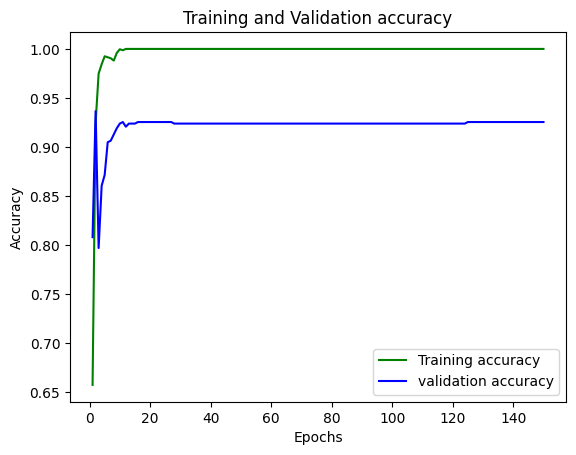

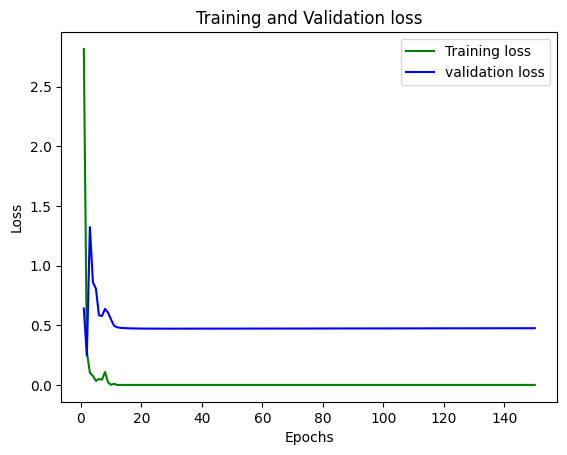

In [19]:
plot_model_accuracy(history)
plot_model_loss(history)

Image generator with a bit more aggressive data augmentation.

In [20]:
# Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

# Validation data should not be augmented
val_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    target_size=(256, 256))

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                       batch_size=32,
                                                       class_mode='sparse',
                                                       target_size=(256, 256))

Found 2940 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


Creating a directory to save models.

In [21]:
save_dir = 'content/best_model2'
os.makedirs(save_dir, exist_ok=True)

Seventeenth model.

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# Define the model
model17 = models.Sequential([
  layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3)),
  LeakyReLU(alpha=0.1),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512),
  LeakyReLU(alpha=0.1),
  layers.Dense(6, activation='softmax')
])

model17.summary()

# Define the checkpoint callback to save the model at each epoch
checkpoint_callback = ModelCheckpoint(
    'content/best_model2/epoch_{epoch:02d}.h5',  # Save the model for each epoch
    save_weights_only=False,  # Save the full model
    save_freq='epoch'  # Save every epoch
)

# Compile the model
model17.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

Training the seventeenth model.

In [23]:
# Train the model
history = model17.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=200,
                    validation_steps=len(validation_generator),
                    verbose=2,
                    callbacks=[checkpoint_callback])

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 - 47s - loss: 1.7014 - accuracy: 0.2741 - val_loss: 1.3512 - val_accuracy: 0.5349 - 47s/epoch - 506ms/step
Epoch 2/200
92/92 - 40s - loss: 1.2036 - accuracy: 0.5357 - val_loss: 0.5973 - val_accuracy: 0.7937 - 40s/epoch - 430ms/step
Epoch 3/200
92/92 - 39s - loss: 0.7840 - accuracy: 0.7228 - val_loss: 0.4344 - val_accuracy: 0.8492 - 39s/epoch - 428ms/step
Epoch 4/200
92/92 - 41s - loss: 0.5818 - accuracy: 0.7959 - val_loss: 0.3410 - val_accuracy: 0.8810 - 41s/epoch - 442ms/step
Epoch 5/200
92/92 - 40s - loss: 0.5234 - accuracy: 0.8201 - val_loss: 0.3242 - val_accuracy: 0.8889 - 40s/epoch - 439ms/step
Epoch 6/200
92/92 - 40s - loss: 0.4441 - accuracy: 0.8480 - val_loss: 0.3650 - val_accuracy: 0.8619 - 40s/epoch - 434ms/step
Epoch 7/200
92/92 - 40s - loss: 0.4246 - accuracy: 0.8558 - val_loss: 0.3043 - val_accuracy: 0.8905 - 40s/epoch - 435ms/step
Epoch 8/200
92/92 - 39s - loss: 0.3786 - accuracy: 0.8707 - val_loss: 0.2350 - val_accuracy: 0.9175 - 39s/epoch - 423ms/step
Epoch 9/200


Results of the seventeenth model.

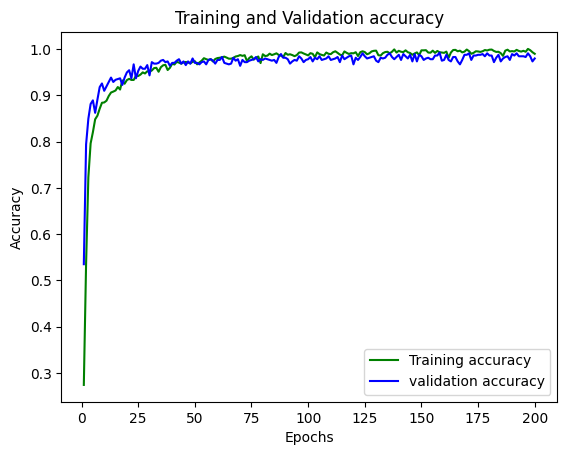

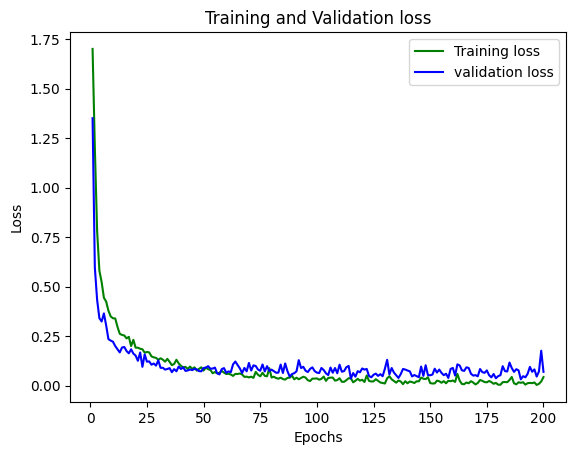

In [24]:
plot_model_accuracy(history)
plot_model_loss(history)